In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import pandas as pd
import numpy as np 

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,HDBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

In [4]:
df = pd.read_csv("dataset_task2.csv")

In [5]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df = df.drop("CustomerID",axis=1)

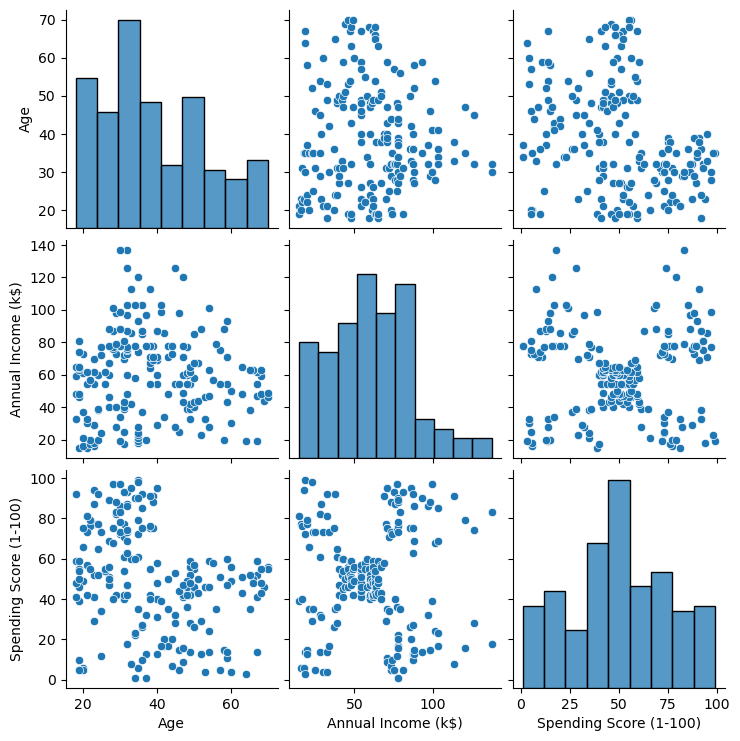

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df)
plt.show()

In [9]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include = ["int64"]).columns.tolist()

In [10]:
ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False),cat_cols),
    (StandardScaler(),num_cols))

In [11]:
ct.set_output(transform="pandas")

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['Gender']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Annual Income (k$)',
                                  'Spending Score (1-100)'])])

In [12]:
df_pre = ct.fit_transform(df)

In [13]:
df_pre

,onehotencoder__Gender_Female,onehotencoder__Gender_Male,standardscaler__Age,standardscaler__Annual Income (k$),standardscaler__Spending Score (1-100)
0,0.0,1.0,-1.424569,-1.738999,-0.434801
1,0.0,1.0,-1.281035,-1.738999,1.195704
2,1.0,0.0,-1.352802,-1.700830,-1.715913
3,1.0,0.0,-1.137502,-1.700830,1.040418
4,1.0,0.0,-0.563369,-1.662660,-0.395980
...,...,...,...,...,...
195,1.0,0.0,-0.276302,2.268791,1.118061
196,1.0,0.0,0.441365,2.497807,-0.861839
197,0.0,1.0,-0.491602,2.497807,0.923953
198,0.0,1.0,-0.491602,2.917671,-1.250054


In [14]:
pre_pipe = make_pipeline(ct,PCA(n_components = 3))

In [15]:
df_pca = pre_pipe.fit_transform(df)

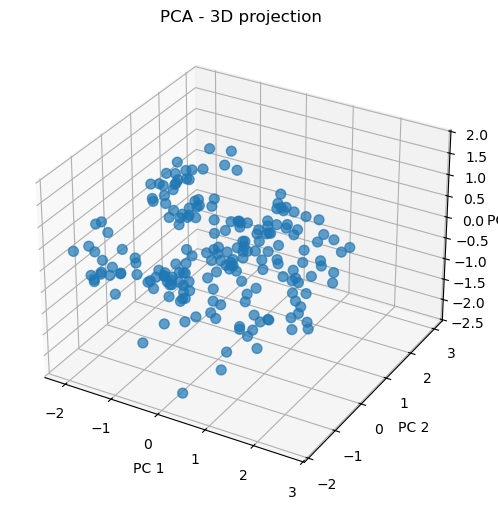

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:,0], df_pca[:,1], df_pca[:,2], s=50, alpha=0.7)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA - 3D projection')
plt.show()

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

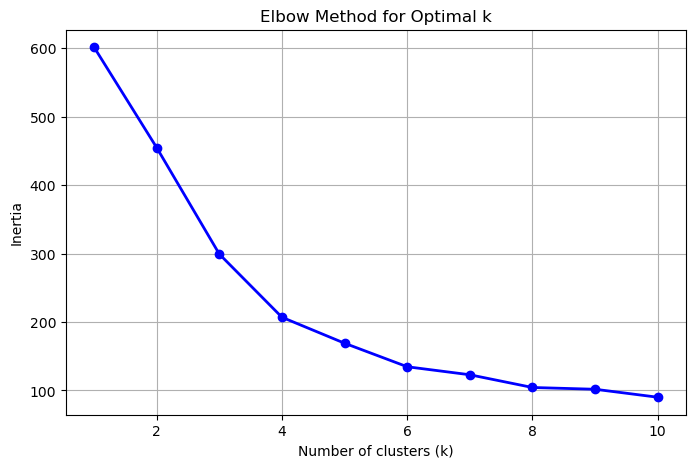

In [18]:
inertia_list = []
k_range = range(1, 11)  # test 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)  # use your PCA-transformed data
    inertia_list.append(kmeans.inertia_)


plt.figure(figsize=(8,5))
plt.plot(k_range, inertia_list, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [19]:
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(df_pca)

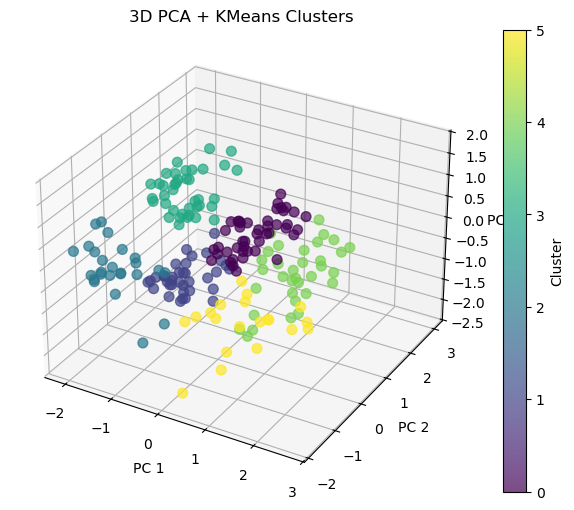

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_pca[:,0], df_pca[:,1], df_pca[:,2], 
    c=labels, cmap='viridis', s=50, alpha=0.7
)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('3D PCA + KMeans Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [21]:
sil_score = silhouette_score(df_pca, labels)
dbi_score = davies_bouldin_score(df_pca, labels)
ch_score = calinski_harabasz_score(df_pca, labels)
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {dbi_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

Silhouette Score: 0.423
Davies-Bouldin Index: 0.834
Calinski-Harabasz Score: 134.556


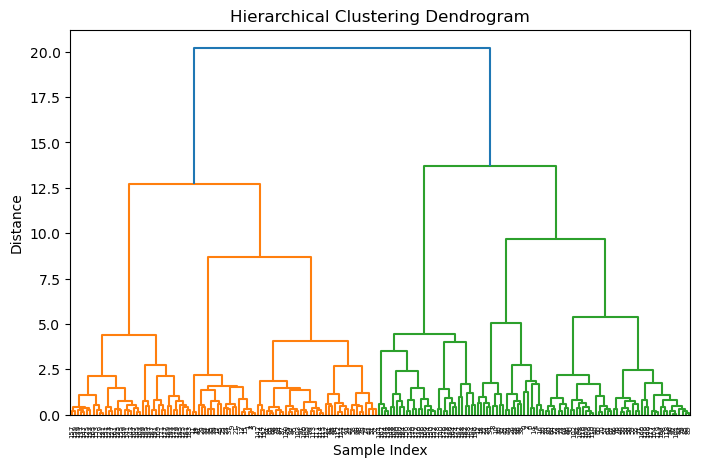

In [22]:
linked = linkage(df_pca, method='ward')  # hierarchical linkage
plt.figure(figsize=(8, 5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [23]:
hc = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels = hc.fit_predict(df_pca)

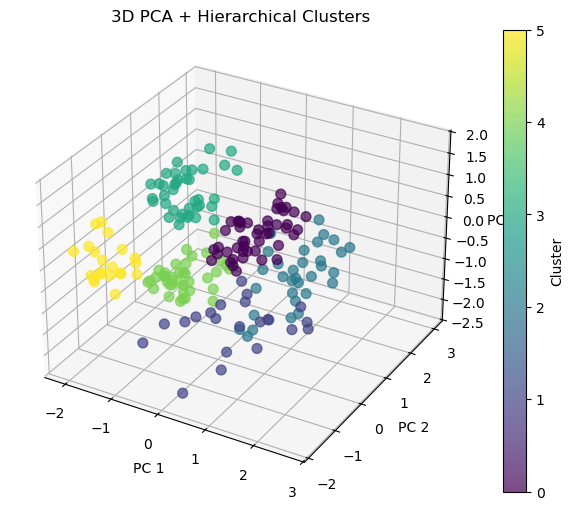

In [24]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_pca[:,0], df_pca[:,1], df_pca[:,2],
    c=labels, cmap='viridis', s=50, alpha=0.7
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('3D PCA + Hierarchical Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [25]:
sil_score = silhouette_score(df_pca, labels)
dbi_score = davies_bouldin_score(df_pca, labels)
ch_score = calinski_harabasz_score(df_pca, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {dbi_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

Silhouette Score: 0.424
Davies-Bouldin Index: 0.832
Calinski-Harabasz Score: 131.271


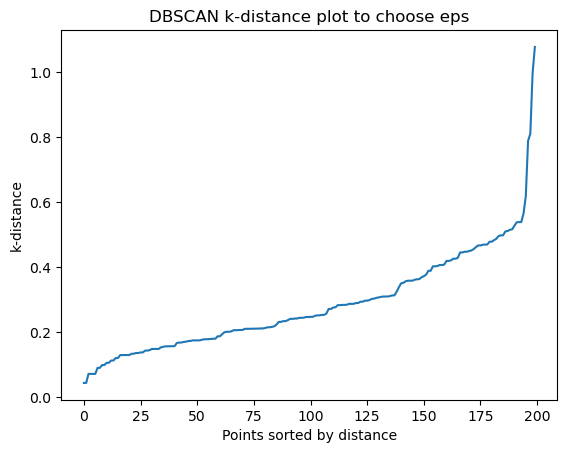

In [26]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances to find the “knee”
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted by distance")
plt.title("DBSCAN k-distance plot to choose eps")
plt.show()


In [33]:
db = DBSCAN(eps=0.32, min_samples=8)
labels = db.fit_predict(df_pca)

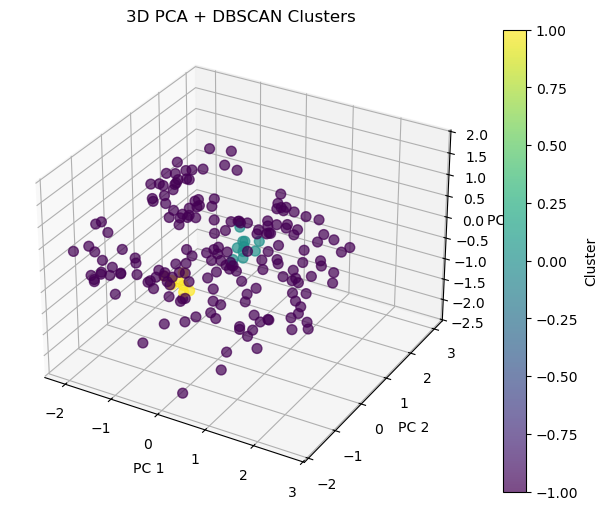

In [34]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Use labels as color; noise (-1) can be in a separate color
scatter = ax.scatter(
    df_pca[:,0], df_pca[:,1], df_pca[:,2],
    c=labels, cmap='viridis', s=50, alpha=0.7
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('3D PCA + DBSCAN Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [35]:
# Filter out noise points for metrics
mask = labels != -1
if mask.sum() > 0:  # check if there are non-noise points
    sil_score = silhouette_score(df_pca[mask], labels[mask])
    dbi_score = davies_bouldin_score(df_pca[mask], labels[mask])
    ch_score = calinski_harabasz_score(df_pca[mask], labels[mask])

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {dbi_score:.3f}")
    print(f"Calinski-Harabasz Score: {ch_score:.3f}")
else:
    print("All points are labeled as noise. Cannot compute metrics.")


Silhouette Score: 0.837
Davies-Bouldin Index: 0.214
Calinski-Harabasz Score: 287.873


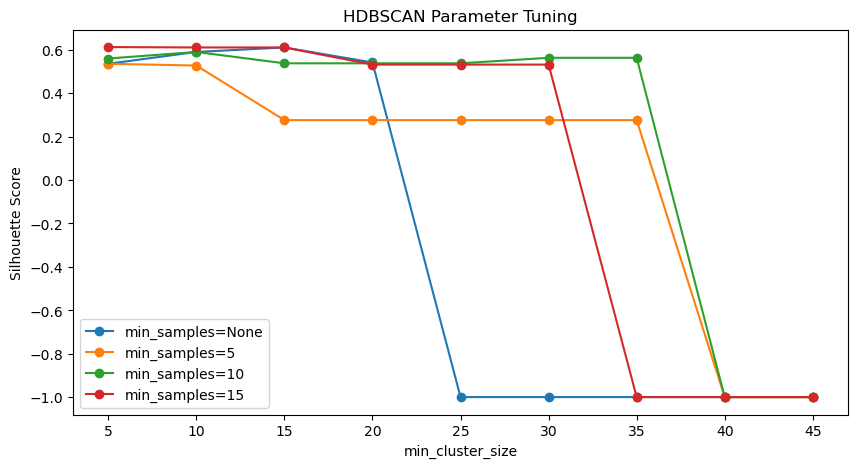

In [30]:
min_cluster_sizes = range(5, 50, 5)
min_samples_values = [None, 5, 10, 15]

results = []

for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        hdb = HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        labels = hdb.fit_predict(df_pca)
        mask = labels != -1  # exclude noise
        
        if len(set(labels[mask])) > 1:
            sil = silhouette_score(df_pca[mask], labels[mask])
        else:
            sil = -1  # invalid clustering
        
        noise_ratio = np.mean(labels == -1)
        results.append((mcs, ms, sil, noise_ratio))


plt.figure(figsize=(10,5))
for ms in min_samples_values:
    x = [r[0] for r in results if r[1] == ms]
    sil = [r[2] for r in results if r[1] == ms]
    plt.plot(x, sil, marker='o', label=f'min_samples={ms}')
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.title('HDBSCAN Parameter Tuning')
plt.legend()
plt.show()





In [31]:
hdb = HDBSCAN(min_cluster_size=5, min_samples=15)
labels = hdb.fit_predict(df_pca)


In [32]:
mask = labels != -1
if mask.sum() > 0:  # check if there are non-noise points
    sil_score = silhouette_score(df_pca[mask], labels[mask])
    dbi_score = davies_bouldin_score(df_pca[mask], labels[mask])
    ch_score = calinski_harabasz_score(df_pca[mask], labels[mask])

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Index: {dbi_score:.3f}")
    print(f"Calinski-Harabasz Score: {ch_score:.3f}")
else:
    print("All points are labeled as noise. Cannot compute metrics.")


Silhouette Score: 0.613
Davies-Bouldin Index: 0.472
Calinski-Harabasz Score: 117.131
